# Pose2 iSAM

The previous "PoseSLAM" example optimized everything in batch. One of the key features of GTSAM is that we can do incremental inference using the iSAM algorithm, as illustrated below.

In [1]:
%pip -q install gtsam==4.2a5

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot

In [2]:
def report_on_progress(graph: gtsam.NonlinearFactorGraph, current_estimate: gtsam.Values,
                        key: int):
    """Print and plot incremental progress of the robot for 2D Pose SLAM using iSAM2."""

    # Print the current estimates computed using iSAM2.
    print("*"*50 + f"\nInference after State {key+1}:\n")
    # print(current_estimate)

    # Compute the marginals for all states in the graph.
    marginals = gtsam.Marginals(graph, current_estimate)

    # Plot the newly updated iSAM2 inference.
    fig = plt.figure(0)
    axes = fig.gca()
    plt.cla()

    i = 1
    while current_estimate.exists(i):
        gtsam_plot.plot_pose2(0, current_estimate.atPose2(i), 0.5, marginals.marginalCovariance(i))
        i += 1

    plt.axis('equal')
    axes.set_xlim(-1, 5)
    axes.set_ylim(-1, 3)
    plt.pause(1)

In [3]:
def determine_loop_closure(odom: np.ndarray, current_estimate: gtsam.Values,
    key: int, xy_tol=0.6, theta_tol=17) -> int:
    """Simple brute force approach which iterates through previous states
    and checks for loop closure.

    Args:
        odom: Vector representing noisy odometry (x, y, theta) measurement in the body frame.
        current_estimate: The current estimates computed by iSAM2.
        key: Key corresponding to the current state estimate of the robot.
        xy_tol: Optional argument for the x-y measurement tolerance, in meters.
        theta_tol: Optional argument for the theta measurement tolerance, in degrees.
    Returns:
        k: The key of the state which is helping add the loop closure constraint.
            If loop closure is not found, then None is returned.
    """
    if current_estimate:
        prev_est = current_estimate.atPose2(key+1)
        rotated_odom = prev_est.rotation().matrix() @ odom[:2]
        curr_xy = np.array([prev_est.x() + rotated_odom[0],
                            prev_est.y() + rotated_odom[1]])
        curr_theta = prev_est.theta() + odom[2]
        for k in range(1, key+1):
            pose_xy = np.array([current_estimate.atPose2(k).x(),
                                current_estimate.atPose2(k).y()])
            pose_theta = current_estimate.atPose2(k).theta()
            if (abs(pose_xy - curr_xy) <= xy_tol).all() and \
                (abs(pose_theta - curr_theta) <= theta_tol*np.pi/180):
                    return k


In [4]:
# Declare the 2D translational standard deviations of the prior factor's Gaussian model, in meters.
prior_xy_sigma = 0.3

# Declare the 2D rotational standard deviation of the prior factor's Gaussian model, in degrees.
prior_theta_sigma = 5

# Declare the 2D translational standard deviations of the odometry factor's Gaussian model, in meters.
odometry_xy_sigma = 0.2

# Declare the 2D rotational standard deviation of the odometry factor's Gaussian model, in degrees.
odometry_theta_sigma = 5

# Although this example only uses linear measurements and Gaussian noise models, it is important
# to note that iSAM2 can be utilized to its full potential during nonlinear optimization. This example
# simply showcases how iSAM2 may be applied to a Pose2 SLAM problem.
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([prior_xy_sigma,
                                                        prior_xy_sigma,
                                                        prior_theta_sigma*np.pi/180]))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([odometry_xy_sigma,
                                                            odometry_xy_sigma,
                                                            odometry_theta_sigma*np.pi/180]))

In [5]:
# Create the ground truth odometry measurements of the robot during the trajectory.
true_odometry = [(2, 0, 0),
                (2, 0, math.pi/2),
                (2, 0, math.pi/2),
                (2, 0, math.pi/2),
                (2, 0, math.pi/2)]

# Corrupt the odometry measurements with gaussian noise to create noisy odometry measurements.
odometry_measurements = [np.random.multivariate_normal(true_odom, ODOMETRY_NOISE.covariance())
                            for true_odom in true_odometry]


In [6]:
# Create iSAM2 parameters which can adjust the threshold necessary to force relinearization and how many
# update calls are required to perform the relinearization.
parameters = gtsam.ISAM2Params()
parameters.setRelinearizeThreshold(0.1)
parameters.relinearizeSkip = 1
isam = gtsam.ISAM2(parameters)

Perform 2D SLAM given the ground truth changes in pose as well as
simple loop closure detection:

**************************************************
Inference after State 1:



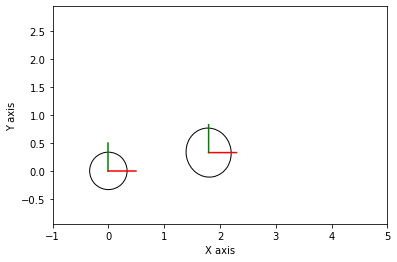

**************************************************
Inference after State 2:



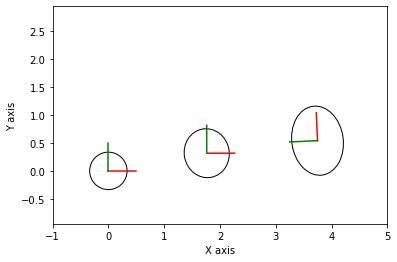

**************************************************
Inference after State 3:



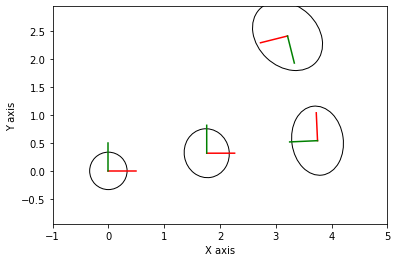

**************************************************
Inference after State 4:



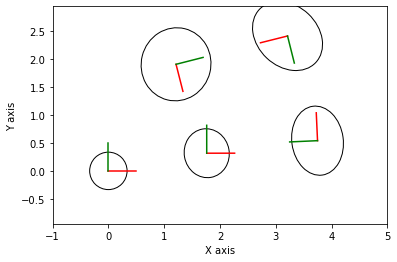

**************************************************
Inference after State 5:



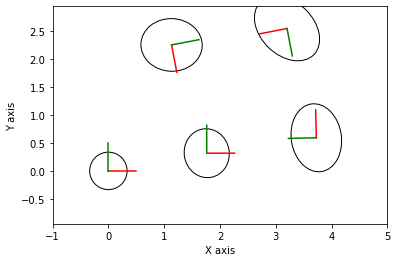

In [7]:
plt.ion()

# Create a Nonlinear factor graph as well as the data structure to hold state estimates.
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Add the prior factor to the factor graph, and poorly initialize the prior pose to demonstrate
# iSAM2 incremental optimization.
graph.push_back(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))

# Initialize the current estimate which is used during the incremental inference loop.
current_estimate = initial_estimate

for i in range(len(true_odometry)):

    # Obtain the noisy odometry that is received by the robot and corrupted by gaussian noise.
    noisy_odom_x, noisy_odom_y, noisy_odom_theta = odometry_measurements[i]

    # Determine if there is loop closure based on the odometry measurement and the previous estimate of the state.
    loop = determine_loop_closure(odometry_measurements[i], current_estimate, i, xy_tol=0.8, theta_tol=25)

    # Add a binary factor in between two existing states if loop closure is detected.
    # Otherwise, add a binary factor between a newly observed state and the previous state.
    if loop:
        graph.push_back(gtsam.BetweenFactorPose2(i + 1, loop, 
            gtsam.Pose2(noisy_odom_x, noisy_odom_y, noisy_odom_theta), ODOMETRY_NOISE))
    else:
        graph.push_back(gtsam.BetweenFactorPose2(i + 1, i + 2, 
            gtsam.Pose2(noisy_odom_x, noisy_odom_y, noisy_odom_theta), ODOMETRY_NOISE))

        # Compute and insert the initialization estimate for the current pose using the noisy odometry measurement.
        computed_estimate = current_estimate.atPose2(i + 1).compose(gtsam.Pose2(noisy_odom_x,
                                                                                noisy_odom_y,
                                                                                noisy_odom_theta))
        initial_estimate.insert(i + 2, computed_estimate)

    # Perform incremental update to iSAM2's internal Bayes tree, optimizing only the affected variables.
    isam.update(graph, initial_estimate)
    current_estimate = isam.calculateEstimate()

    # Report all current state estimates from the iSAM2 optimzation.
    report_on_progress(graph, current_estimate, i)
    initial_estimate.clear()

plt.ioff()
plt.show()

In [8]:
# Print the final covariance matrix for each pose after completing inference on the trajectory.
marginals = gtsam.Marginals(graph, current_estimate)
i = 1
for i in range(1, len(true_odometry)+1):
    print(f"X{i} covariance:\n{marginals.marginalCovariance(i)}\n")

X1 covariance:
[[ 9.00000000e-02 -3.37968240e-18 -8.52247048e-18]
 [-3.37968240e-18  9.00000000e-02  3.89598651e-17]
 [-8.52247048e-18  3.89598651e-17  7.61543549e-03]]

X2 covariance:
[[ 0.13075722 -0.004233   -0.00240137]
 [-0.004233    0.1536633   0.0134241 ]
 [-0.00240137  0.0134241   0.01523087]]

X3 covariance:
[[0.29774845 0.01774521 0.04541913]
 [0.01774521 0.1639351  0.0042845 ]
 [0.04541913 0.0042845  0.02025829]]

X4 covariance:
[[ 0.2392119  -0.08432109  0.0352123 ]
 [-0.08432109  0.30169294 -0.04762872]
 [ 0.0352123  -0.04762872  0.02159453]]

X5 covariance:
[[ 0.18121778  0.01416991 -0.00702734]
 [ 0.01416991  0.23826225 -0.03958449]
 [-0.00702734 -0.03958449  0.020409  ]]

